# IP Generator

In [3]:
import pandas as pd
import numpy as np
import pickle
import pyodbc
import os
import sys

# Needs pandas_utils and custom_tfs
sys.path.append("C:/Users/adi/OneDrive/Work/Pyxll/common/helpers")
from generic_utils import *
from custom_tfs import *
from numba import jit, prange
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
%load_ext nb_black

<IPython.core.display.Javascript object>

### Needs 1002a, formations, allocations, section_assumptions data

In [5]:
# db connections
driver = "{ODBC Driver 17 for SQL Server}"
server = "syntax-dev-sql.database.windows.net"
port = 1443

user = os.environ["ALLSQUARE_USERNAME"]
pwd = os.environ["ALLSQUARE_PASSWORD"]
auth = "ActiveDirectoryPassword"
cnxns = dict()
dbs = ["syntax_dev", "syntax_dev_hist", "stg_cg_export"]
for db in dbs:
    cnxn_string = f"DRIVER={driver};PORT={port};SERVER={server};PORT={port};DATABASE={db};UID={user};PWD={pwd};Authentication={auth}"
    cnxns[db] = pyodbc.connect(cnxn_string)

InterfaceError: ('28000', "[28000] [Microsoft][ODBC Driver 17 for SQL Server][SQL Server]Login failed for user 'NT AUTHORITY\\ANONYMOUS LOGON'. (18456) (SQLDriverConnect); [28000] [Microsoft][ODBC Driver 17 for SQL Server]Invalid connection string attribute (0); [28000] [Microsoft][ODBC Driver 17 for SQL Server][SQL Server]Login failed for user 'NT AUTHORITY\\ANONYMOUS LOGON'. (18456); [28000] [Microsoft][ODBC Driver 17 for SQL Server]Invalid connection string attribute (0)")

<IPython.core.display.Javascript object>

## F1002a:
 IP generator needs wells tagged with formations. Hence reading from the result of Formation Normalization

In [6]:
f1002a = pd.read_pickle("../data/eff_sec_form_norm.pickle")

f1002a = f1002a.pipe(ccast, (["api"], tf_api)).pipe(
    ccast, (["formation"], tf_formation)
)

FileNotFoundError: [Errno 2] No such file or directory: '../data/eff_sec_form_norm.pickle'

<IPython.core.display.Javascript object>

## Max30

In [16]:
# code for dbo.v_adi_production_monthly
# SELECT        W.api, W.surface_trsm_heh, W.bottomhole_trsm_heh, P.reporting_date, CASE WHEN P.oil_gross_volume >= 155000 THEN 0 ELSE P.oil_gross_volume END AS oil_gross_volume,
#                          CASE WHEN P.gas_gross_volume >= 1550000 THEN 0 ELSE P.gas_gross_volume END AS gas_gross_volume, P.pun
# FROM            dbo.p_otc_monthly AS P INNER JOIN
#                          dbo.index_well AS W ON P.pun = W.pun
# WHERE        (W.is_horizontal = 1) AND (P.reporting_date IS NOT NULL)

get_max_30_ip = """
SELECT
    api,
    reporting_date,
    oil_gross_volume as oil,
    gas_gross_volume as gas
    from dbo.v_adi_production_monthly
"""

<IPython.core.display.Javascript object>

In [17]:
production = pd.read_sql(get_max_30_ip, cnxns["stg_cg_export"])

<IPython.core.display.Javascript object>

In [18]:
def tf_stream_production(x):
    return x.astype("float32").fillna(0)

<IPython.core.display.Javascript object>

In [19]:
production = (
    production.pipe(ccast, (["api"], tf_api))
    .pipe(ccast, (["reporting_date"], tf_date))
    .pipe(ccast, (["oil", "gas"], tf_stream_production))
)

<IPython.core.display.Javascript object>

In [20]:
f1002a_api = f1002a.api.unique()

<IPython.core.display.Javascript object>

In [21]:
df_prod = production.query("api in @f1002a_api").reset_index(drop=True)

<IPython.core.display.Javascript object>

In [22]:
max30 = (
    df_prod.sort_values(["api", "reporting_date"])
    .reset_index(drop=True)
    .groupby(["api"], as_index=False)
    .agg({"oil": "max", "gas": "max"})
    .reset_index(drop=True)
    .rename(columns={"oil": "max30_oil", "gas": "max30_gas"})
)

<IPython.core.display.Javascript object>

## 1002 IP

In [23]:
get_f1002_ip = """
SELECT
    id,
    n_api as api,
    test_date,
    oil_bbl_per_day as oil,
    gas_mcf_per_day as gas
FROM dbo.r_occ_w27_test
"""

<IPython.core.display.Javascript object>

In [24]:
ip_f1002 = (
    pd.read_sql(get_f1002_ip, cnxns["stg_cg_export"])
    .pipe(ccast, (["api"], tf_api))
    .query("api in @f1002a_api")
    .reset_index(drop=True)
    .pipe(ccast, (["test_date"], tf_date))
    .pipe(ccast, (["oil", "gas"], tf_stream_production))
    .rename(columns={"oil": "f1002_oil", "gas": "f1002_gas"})
)

<IPython.core.display.Javascript object>

## Section

In [25]:
get_section = """
SELECT
    trsm_heh,
    cartesian_x,
    cartesian_y
FROM dbo.index_ok_sections_nad83_polygon
"""

<IPython.core.display.Javascript object>

In [26]:
section = pd.read_sql(get_section, cnxns["stg_cg_export"]).pipe(
    ccast, (["cartesian_x", "cartesian_y"], tf_cartesian)
)

<IPython.core.display.Javascript object>

In [27]:
columns = [
    "api",
    "well_name",
    "formation",
    "cartesian_x",
    "cartesian_y",
    "f1002_oil",
    "f1002_gas",
    "max30_oil",
    "max30_gas",
]

<IPython.core.display.Javascript object>

In [314]:
df = (
    f1002a.merge(section, on="trsm_heh")
    .merge(
        ip_f1002.loc[:, ["id", "f1002_oil", "f1002_gas"]], on="id", how="left"
    )
    .merge(max30, on="api", how="left")
    .loc[:, columns]
    .fillna(0)
)

<IPython.core.display.Javascript object>

## Removing wells that doesn not have normalized formation

In [315]:
df = df.query("formation != ''").reset_index(drop=True)

<IPython.core.display.Javascript object>

In [316]:
formations = df.formation.unique()
replace_form_no = {formation: i for i, formation in enumerate(formations)}

<IPython.core.display.Javascript object>

In [317]:
df = df.assign(
    formation_code=lambda x: x.formation.replace(replace_form_no).astype(
        "uint8"
    )
)

<IPython.core.display.Javascript object>

In [318]:
int_array = (
    df.loc[:, ["cartesian_x", "cartesian_y", "formation_code"]]
    .values.astype("int16")
    .transpose()
)
float_array = df.loc[
    :, ["f1002_oil", "max30_oil", "f1002_gas", "max30_gas"]
].values.transpose()

<IPython.core.display.Javascript object>

## Setting values

In [319]:
def grid_set_values(int_array, float_array, nformations):
    xmin = int_array[0].min()
    xmax = int_array[0].max()
    ymin = int_array[1].min()
    ymax = int_array[1].max()

    float_type = float_array.dtype
    int_type = int_array.dtype
    # nformations_int = nformations.astype(int_type)

    result = np.zeros(
        shape=(np.int64(nformations), 2, xmax + 1, ymax + 1)
    ).astype(float_type)

    for j in range(nformations):
        ip_array_oil = np.zeros(shape=(xmax + 1, ymax + 1)).astype(float_type)
        ip_array_gas = np.zeros(shape=(xmax + 1, ymax + 1)).astype(float_type)

        form_mask = int_array[2] == j
        co_array = int_array[:2, form_mask]
        ip_array = float_array[:, form_mask]
        for i in range(co_array.shape[1]):
            oil_ip_values = np.array(
                [
                    ip_array_oil[co_array[0][i]][co_array[1][i]],
                    ip_array[0][i],
                    ip_array[1][i],
                ]
            )
            ip_array_oil[co_array[0][i]][co_array[1][i]] = np.max(oil_ip_values)

            gas_ip_values = np.array(
                [
                    ip_array_gas[co_array[0][i]][co_array[1][i]],
                    ip_array[2][i],
                    ip_array[3][i],
                ]
            )
            ip_array_gas[co_array[0][i]][co_array[1][i]] = np.max(gas_ip_values)

        result[j][0] = ip_array_oil
        result[j][1] = ip_array_gas

    return result

<IPython.core.display.Javascript object>

In [320]:
%%timeit
nformations = np.uint16(14).astype(int_array.dtype)
grid_set_values(int_array, float_array, nformations)

256 ms ± 21.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<IPython.core.display.Javascript object>

In [321]:
nb_grid_set_values = jit(
    grid_set_values, nopython=True, fastmath=True, error_model="numpy"
)

<IPython.core.display.Javascript object>

In [322]:
%%timeit
nb_grid_set_values(int_array, float_array, nformations)

30.8 ms ± 2.57 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<IPython.core.display.Javascript object>

In [323]:
result = nb_grid_set_values(int_array, float_array, nformations)

<IPython.core.display.Javascript object>

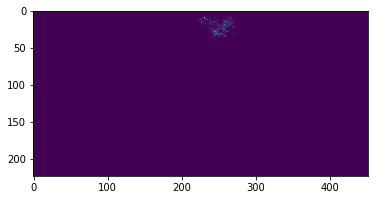

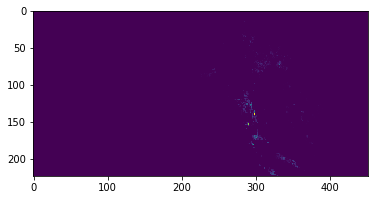

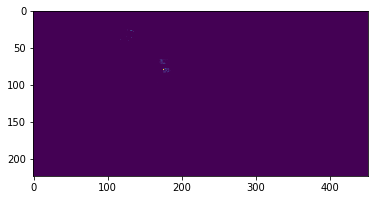

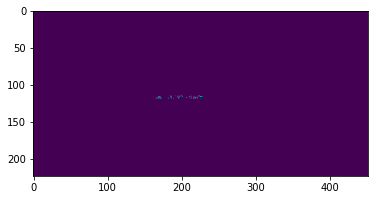

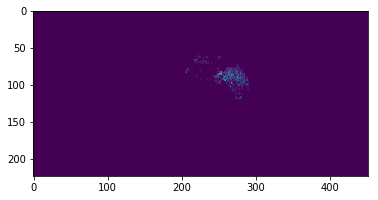

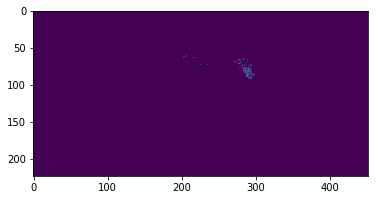

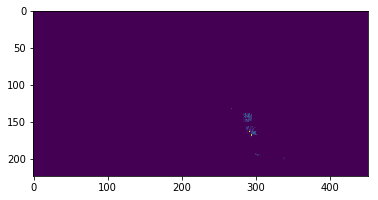

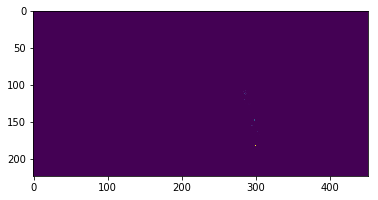

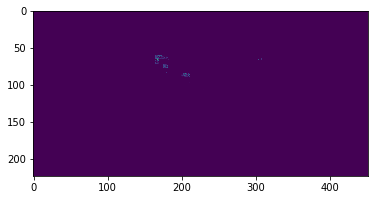

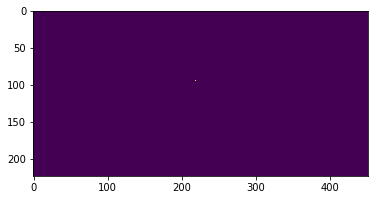

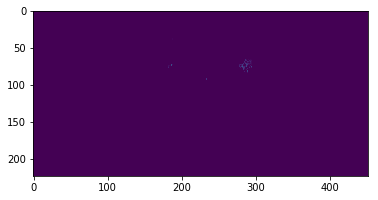

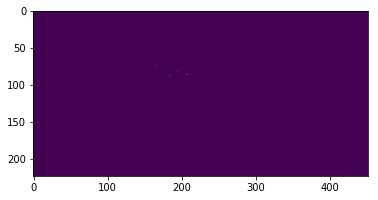

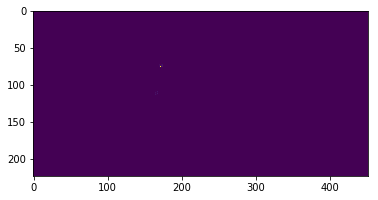

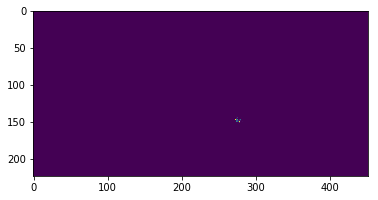

<IPython.core.display.Javascript object>

In [324]:
for i in range(nformations):
    plt.imshow(result[i][0].transpose())
    plt.show()

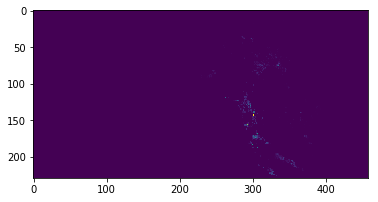

<IPython.core.display.Javascript object>

In [325]:
plt.imshow(np.pad(result[1][0], pad_width=3, mode="constant").transpose())

In [351]:
def spot_radius_average(ip_pad, radius):
    """
    ip_pad - (Formation x Stream x Cartesian_X x Cartesain_Y).
    It should be padded
    radius - radius to do average
    """
    idx_dtype = np.int16

    nforms = idx_dtype(ip_pad.shape[0])
    nstreams = idx_dtype(ip_pad.shape[1])
    xmax = idx_dtype(ip_pad.shape[2])
    ymax = idx_dtype(ip_pad.shape[3])
    r = idx_dtype(radius)

    ip_radius_max = np.zeros_like(ip_pad)
    for f in range(nforms):
        for s in range(nstreams):
            lower = -r
            upper = r + idx_dtype(1)
            n = (idx_dtype(r) * idx_dtype(2) + idx_dtype(1)) ^ idx_dtype(2)
            for i in range(r, xmax - r):
                for j in range(r, ymax - r):
                    sum_ip_spot = np.float32(0)
                    for spot_x in range(lower, upper):
                        for spot_y in range(lower, upper):
                            sum_ip_spot += (
                                ip_pad[f][s][i + spot_x][j]
                                + ip_pad[f][s][i][j + spot_y]
                            )
                    ip_radius_max[f][s][i][j] = sum_ip_spot / n

    return ip_radius_max

<IPython.core.display.Javascript object>

In [352]:
radius = np.int(2)
npads = radius * 2

<IPython.core.display.Javascript object>

In [353]:
nforms = result.shape[0]
nstreams = result.shape[1]
maxx = result.shape[2]
maxy = result.shape[3]

result_pad = np.zeros(
    shape=(nforms, nstreams, maxx + npads, maxy + npads), dtype=result.dtype
)
for i in range(formations.shape[0]):
    for j in range(2):
        result_pad[i][j] = np.pad(
            result[i][j], pad_width=radius, mode="constant"
        )

<IPython.core.display.Javascript object>

In [354]:
result.shape, result_pad.shape

((14, 2, 452, 223), (14, 2, 456, 227))

<IPython.core.display.Javascript object>

In [299]:
%%time
radius = np.int(2)
spot_radius_average(result, radius)

Wall time: 2min 15s


<IPython.core.display.Javascript object>

In [355]:
nb_spot_radius_average = jit(
    spot_radius_average, nopython=True, fastmath=True, error_model="numpy"
)

<IPython.core.display.Javascript object>

In [359]:
%%timeit
ip = nb_spot_radius_average(result_pad, radius)

109 ms ± 4.26 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<IPython.core.display.Javascript object>

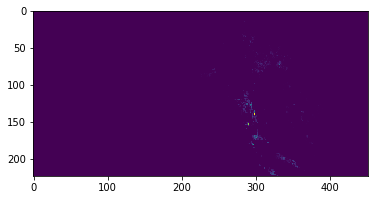

<IPython.core.display.Javascript object>

In [364]:
plt.imshow(result[1][0].transpose())

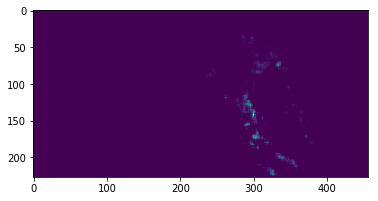

<IPython.core.display.Javascript object>

In [365]:
plt.imshow(ip[1][0].transpose())